## warehouse collision 해결하고 warehouse에 코드로 넣기

### deadend 해결을 heuristic map으로 구현한다면, navigate 설정을 조금 바꿔야 함 (어렵지 않음)

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [2]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

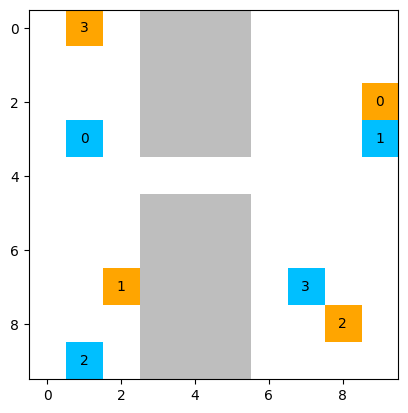

In [3]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0]]), np.array([[3, 1], [3, 9], [9, 1], [7, 7]]), np.array([[2, 9], [7, 2], [8, 8], [0, 1]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [4]:
class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Which direction do you move next?
        {last_action}
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )
  
  #수정 필요(다른 pathfinder를 그냥 동쪽에 있는걸로 해놨는데, observe한 환경에서 가장 번호가 높은 pathfinder의 상대적인 위치를 받아오도록 고쳐야 함)
  def give_way(self, agent, east, west, north, south, direction):
    return Task(
      description=(
        f"""
        You MUST avoid collisions with prior path finder.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        To the {direction} of you is prior path finder.
        Which direction do you move next?
        I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [5]:
#에이전트들의 지난번 액션들
action_list = [[] for _ in range(num_agents)]



> Entering new CrewAgentExecutor chain...


2024-06-17 18:30:40,916 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is at (1,6) and my destination is at (9,7), it's clear that I need to move towards the east to increase my x-coordinate value from 1 to 9. Also, the environment details mention that there is a path to the east. Therefore, my next move should be towards the east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:30:45,798 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that my current location is at (9,6) and my destination is at (2,2), I need to move both south and west. However, I can only move in one direction at a time. Therefore, it doesn't matter if I go south or west first, I will eventually reach my destination. I'll choose to move west first in this case.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:30:47,862 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates and the destination, the best move would be to go east towards the x-axis increment. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current coordinates (7,2) and my destination (1,9), I need to move northward to increase my y-coordinate and westward to decrease my x-coordinate. As paths lie in all directions, I can choose either of these directions. However, choosing north first will bring me closer to the destination on the y-axis.

Final Answer: North

> Finished chain.


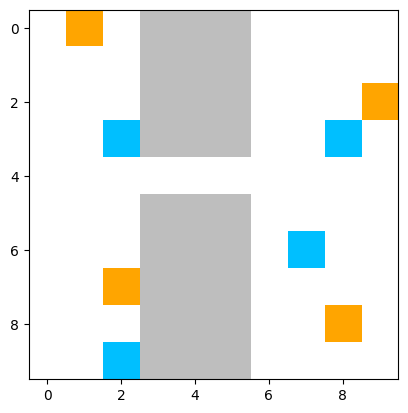

2024-06-17 18:30:52,422 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:30:57,603 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates (2,6), the destination coordinates (9,7), and the available paths, I need to move towards the destination which is more towards the east. However, as the path towards the east is blocked, I need to find an alternate route. Given that I can move west, south and north, and I came from the west, it would be best to head north or south to eventually find a path that leads east.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:01,245 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (8,6) and my destination (2,2), I need to move towards the west and south. However, since I just came from the east, I should move west to avoid backtracking. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:06,580 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current location is (2,0), and I need to reach (8,1), it would be ideal to move east, but that path is blocked by a wall. Since I came from the west, I should avoid going back. Thus, the logical move is to go either north or south. Considering that the destination coordinates have a higher y value (1 compared to 0), I should move north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
To reach my destination from (7,3) to (1,9), I need to move towards the west and north. Since I came from the south, I should avoid moving in that direction. I must decide whether to move west or north first. Since my x-coordinate is higher than my y-coordinate, it would be more efficient to move west first to decrease the x-coordinate.

Final Answer: West

> Finished chain.


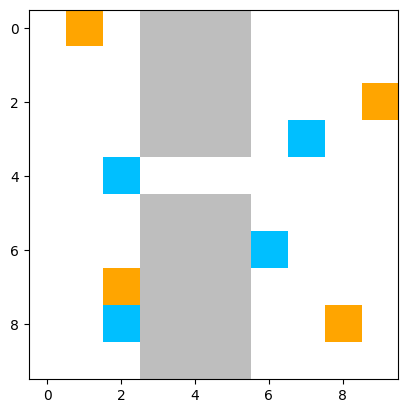

2024-06-17 18:31:12,587 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:18,080 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I am currently at coordinates (2,5) and my destination is (9,7), I need to move towards the east to increase my x coordinate and towards the north to increase my y coordinate. Since I just came from the north and there are paths in all directions, I will choose to move east to progress towards my destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:26,853 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location and the destination, I am currently at a higher location both in terms of the x and y coordinates. Since I came from the east, it would be best to head towards the west or south. However, since moving west would bring me closer to my destination in terms of both x and y coordinates, my best option would be to move west.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:30,509 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I need to move from (2,1) to (8,1) along the x axis, and east is blocked by a wall, the only logical decision here would be to move west, then find a path that leads east without any obstructions.
Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position is (6,3) and my goal is to reach (1,9), I need to move towards the north to increase my y-coordinate. However, I came from east and my west is blocked by a wall. Therefore, my best option is to continue moving North.

Final Answer: North

> Finished chain.


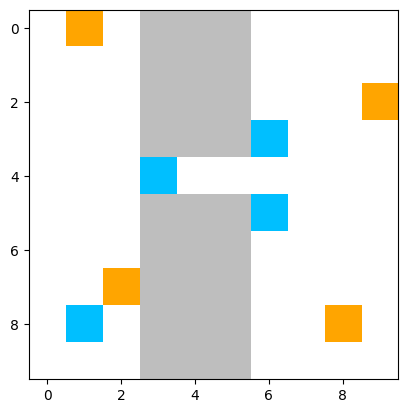

2024-06-17 18:31:35,138 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:38,430 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates and the destination, I need to move eastward to increase the x-coordinate. Moving west would take me back and north and south are blocked. Therefore, the logical choice is to move east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:42,601 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I'm currently at (1,1) and my destination is (8,1), I need to move towards the east to increase my x-coordinate while keeping my y-coordinate the same. Since moving east is available and I came from east, there is no need to change direction.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:48,279 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and my destination, it would be best to move in a direction that brings me closer to the target. Since my current position is (6,6) and my destination is (2,2), I need to move west or south. However, since my west is blocked by a wall, I must choose to move south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:31:52,135 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (6,4) and my destination (1,9), I need to move northward to increase my y-coordinate and westward to decrease my x-coordinate. However, my west is blocked by a wall. Therefore, I should move North to increase my y-coordinate.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current situation, the best option is to move to the east. This is because the east is free of obstacles, and moving to the north would bring me closer to the prior pathfinder, which has to be avoided. So, moving east is the optimal choice.

Final Answer: East

> Finished chain.


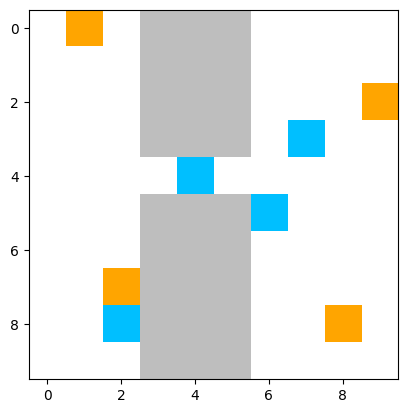

2024-06-17 18:31:56,130 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:01,377 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (2,1) and my destination (8,1), I need to move along the x-axis to the east (right) to reach my goal. However, east is blocked by a wall. Since I just came from the west, it wouldn't be beneficial to backtrack. Therefore, my best option would be to either go north or south to bypass the wall, then continue eastward. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:04,557 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and my destination, I need to move towards the east to reach my goal. Since both east and west are open paths and north and south are blocked, the logical move would be to move east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:09,842 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates are (7,6) and the destination is (2,2), it's apparent that I need to move towards the west and the south. However, I can only make one move at a time. Since both directions are available, the choice of initial direction doesn't particularly matter. I could start by heading west.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current location (6,4) and my desired destination (1,9), I need to move more towards the north and west. However, going west is not an option because there is a wall. The best course of action would therefore be to move north, which is open and leads me closer to the desired y-coordinate.

Final Answer: North

> Finished chain.


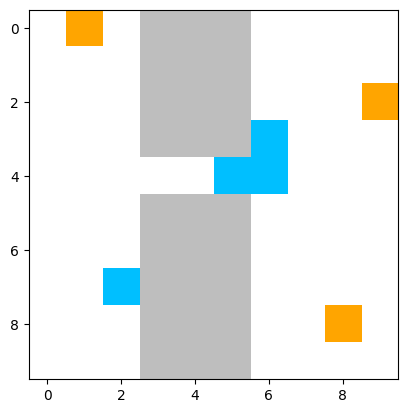

2024-06-17 18:32:14,438 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:19,963 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I can't move east due to the wall and I just came from the south, the logical options would be either to move north or west. However, considering my destination coordinates (8,1), moving west would be counterproductive as it would take me further away from my destination. Therefore, the best move would be to go north.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:25,347 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location is (5,5) and my destination is (9,7), I need to move towards the east to increase my x coordinate. Since my south and north are blocked by walls, east is the only logical direction to move towards my destination. Also, I came from the west, so I would not want to backtrack. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:29,983 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (6,6) and I need to get to (2,2), I need to move both westward and southward. However, my west is blocked by a wall. Thus, the only logical direction to move next would be south.

Final Answer: South.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:37,588 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In order to reach my destination of (1,9) from my current location of (6,5), I need to move northwards to increase my position along the y-axis, and westwards to decrease my position along the x-axis. However, I can only move in one direction at a time. Considering my current position and the fact that I came from the south, the logical choice would be to first move in the direction that would bring me closer to my destination on both axes. Therefore, I should move North.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:41,166 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on the information given, I am blocked on the south and north by walls, there is a prior path finder to my east, and a path to my west. Therefore, the only possible direction for me to move without colliding into a wall or another path finder is to the west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the situation, the only safe and logical move would be to go to the east. Since the west is blocked by a wall and to the south lies the prior path finder, moving east seems to be the most suitable option as it will help avoid a collision with the prior pathfinder and also adhere to the recommendation of taking a 90-degree turn. 

Final Answer: East

> Finished chain.


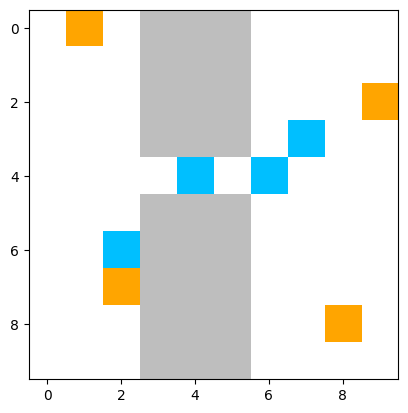

2024-06-17 18:32:46,113 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:49,388 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position and the directions available, the most logical move would be to head towards my destination which is more towards the East. The path is open in that direction and it gets me closer to the point (9,7).

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:32:58,204 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates are (7,6) and the destination is (2,2), I need to move towards the west and south to reach the destination. However, I can only make one move at a time. Therefore, my immediate next move should be either west or south. Since there's no specific obstacle or advantage in either direction, I can choose any. I decide to go west first.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:02,209 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that I'm currently at coordinates (2,3) and my destination is (8,1), I need to move towards the east to increase my x-coordinate and towards the south to decrease my y-coordinate. However, since the east is blocked, my only logical move is to go south to decrease my y-coordinate.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:05,127 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location and the destination, I need to move towards the north and the west. However, since I just came from the south, I will move west first to avoid backtracking. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:08,218 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the information provided, going to the east would result in a collision with the prior path finder. As the south and the north are blocked by walls, the only direction left to move without crashing into anything is to the west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:11,983 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current situation and the recommendation to move to the 90-degree turn rather than the other side of the pathfinder, I would choose to move in a direction that avoids a collision with the prior pathfinder and also leads me closer to my goal.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on the directions given, moving east is not an option as it's blocked by a wall. The prior pathfinder is to the northeast, so moving north could potentially lead to a collision. The recommendation to choose a 90-degree turn seems to suggest avoiding the pathfinder's direction. Thus, the safest options seem to be moving west or south. 

Final Answer: West.

> Finished chain.


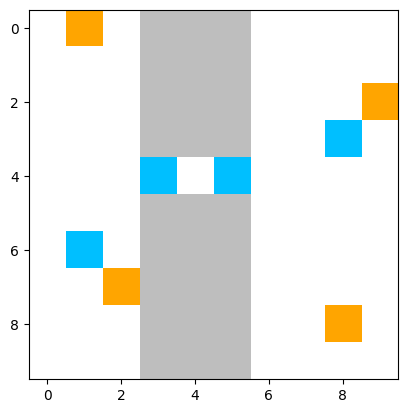

2024-06-17 18:33:17,037 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:21,560 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is at (8,6) and my destination is at (2,2), I need to move both westwards and southwards to reach the destination. Since there's a path available in all directions, I can choose either way. But to minimize the distance in the x-axis, I will choose to move west first.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:25,829 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current location is (3,5) and my destination is (9,7), I need to move towards the east to increase my x-coordinate and towards the north to increase my y-coordinate. However, my north is blocked by a wall. Thus, the only viable option is to move east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:30,357 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the coordinates, I can see that I am situated at (1,3) and I need to reach (8,1). To get there, I need to move mainly towards east and a bit towards south. Since there are paths available in all directions, I can choose the most effective route. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:36,160 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (5,5) and my destination (1,9), I need to move towards the west and north. However, my path to the north is currently blocked by a wall. I also came from the east, so going back is not an optimal move. To my east and west lie paths; since I need to go in the direction of the west to reach the x-coordinate of my destination, the best move for me would be towards the west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:40,668 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current situation, moving east would lead to a collision with the prior pathfinder. Moving west seems to be the optimal choice as it is the only other path available. The north and south paths are blocked by a wall and staying would not allow me to progress towards the end point.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current task, I am aware that I need to avoid a collision with the prior path finder located to my northeast. Also, I have paths in all four directions: east, west, south, and north. Keeping in mind the recommendation to opt for a 90-degree turn rather than moving to the other side of the pathfinder, I'll have to decide my next move.

Final Answer: 
South

> Finished chain.


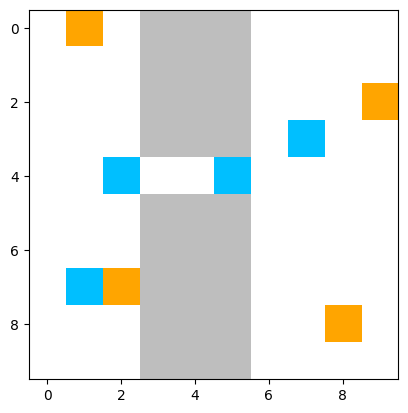

2024-06-17 18:33:46,035 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:48,617 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current location is (2,5) and my goal is (9,7), it's clear that I should move towards the east to increase my x-coordinate.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:52,704 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (1,2) and my destination is (8,1), I need to move towards the east to increase my x-coordinate and towards the south to decrease my y-coordinate. Since all paths are available to me and there are no obstacles in any direction, I should prioritize moving east towards my destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:33:56,866 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (7,6) and I need to reach (2,2), I have to move southwards and westwards. Since I came from the east, going back in the same direction would not be helpful. Hence, the best move would be to move in the south direction.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current position and the destination, I need to move towards the north and west. However, the north is blocked by a wall, so my only option is to move west.

Final Answer: West

> Finished chain.


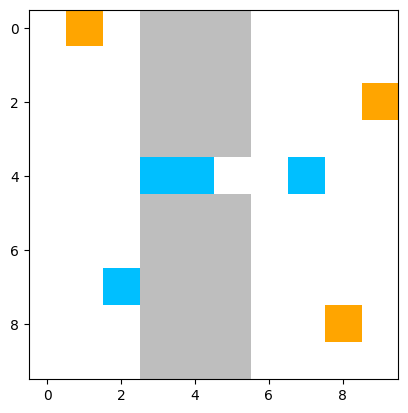

2024-06-17 18:33:59,984 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:03,271 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is (7,5) and my destination is (2,2), I need to move towards the west and south. As I just came from the north, it would be logical to first start moving to the west and then move south.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:09,883 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current location (2,2) and my destination (8,1), I need to move along the x axis towards the east to reach the destination. However, the east is blocked by a wall. The south and north directions have paths, but moving in these directions will not bring me closer to my destination on the x axis. Going back to the west is also not a good option as it will take me further away from my destination. Thus, the best choice seems to be to stay and reassess the situation.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:13,729 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given the current coordinates and the destination coordinates, it is clear that I need to move towards the east to approach the destination. This is also supported by the fact that a path lies to the east and I came from the west. My south and north are blocked, so I have no other options.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:18,030 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the available paths, moving west seems to be the best option. The destination lies to the north but currently, it is blocked by a wall. So, I will have to find a way around. Since I just came from east and there is a wall on the south, the only logical direction to move would be west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current situation, my east is blocked by a prior path finder and my south and north are blocked by walls. The only feasible option left for me is to move west.

Final Answer: West

> Finished chain.


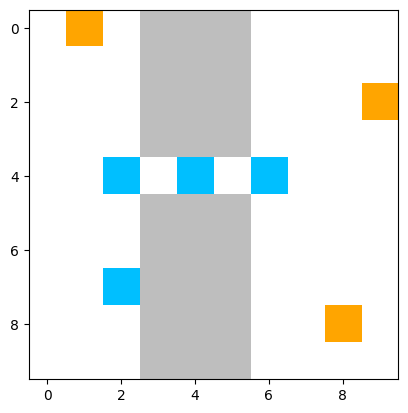

2024-06-17 18:34:21,696 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:28,050 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I can't move east because it's blocked by a wall and my destination (8,1) is to the east of my current position (2,2), I'll need to find a way around the wall. The only available directions are west, south and north. Moving west would take me further from my destination, so it's not the best choice. Moving north or south might allow me to bypass the wall and then move east. Since the y-coordinate of my destination is less than my current y-coordinate, moving south might bring me closer to my goal.

Final Answer: South.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:33,696 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current position and the destination, it is clear that I need to move towards the east to increase the x-coordinate from 2 to 9 and towards the north to increase the y-coordinate from 5 to 7. Since all directions are open and I can move in any direction, the best strategy would be to prioritize the direction where I need to cover more distance. Hence, I need to move towards the east first.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:39,849 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position, I need to move towards the west and south to reach my destination. As I came from the east, I should avoid moving in the same direction again to prevent going back. There are paths in all directions, but to get closer to my target, I should move west or south. Since the x-coordinate (6) is greater than the y-coordinate (5), I will prioritize moving west to decrease the x-coordinate.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:46,245 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates and destination, along with the information regarding the paths and obstacles around me, I need to move in a direction that brings me closer to the destination without hitting a wall. Since I am currently at (4,5) and need to reach (1,9), and knowing that moving north or south is not an option due to the walls, I need to decide between moving east or west. Since I came from the east, it would be logical to move west to change my x-coordinate and get closer to the destination. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:48,761 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current situation, moving east would lead to a collision with the prior path finder. Therefore, I must choose between the other three directions - west, south, or north. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the situation, I can't go west because the prior path finder is there. I can choose to go east, north, or south. Given the recommendation to take the 90-degree turn, I will choose either north or south. Since there's no further information to differentiate between these two, I'll choose one randomly.

Final Answer: North.

> Finished chain.


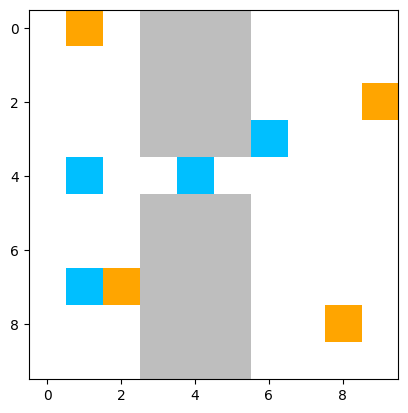

2024-06-17 18:34:53,425 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:34:57,081 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering the current coordinates and the destination, I need to move more on the x-axis (east-west) than on the y-axis (north-south). Since there's a path to my east, I should move in that direction to get closer to the destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:02,903 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position at (1,2) and my destination at (8,1), it's clear that I need to move more towards the east to increase my x-coordinate. Since I can also move south to decrease my y-coordinate to match that of the destination, I have two possible options. However, since I just came from the north, I should prioritize moving east to create distance from my previous position.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:08,801 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates (6,6) and my destination (2,2), I need to move in the direction that brings me closer to my destination. Since I can only move East, West, North and South and my west is blocked by a wall, my best option would be to move South or North. However, since moving North would take me further away from my destination, I should move South.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position and the destination, it seems like I should move towards the west as the south and north are blocked by walls and I just came from the east. 

Final Answer: West

> Finished chain.


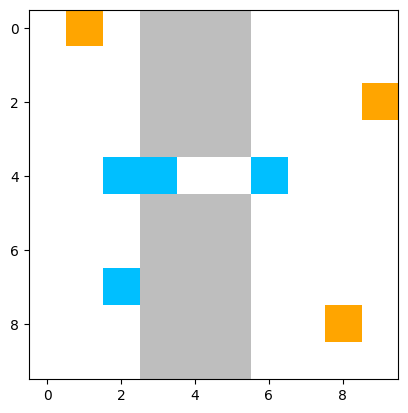

2024-06-17 18:35:12,243 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:17,379 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In order to reach my destination from my current coordinates (6,5) to (2,2), I need to move west and south. Given that I came from the north, I should not move in that direction. Therefore, my next move should be either west or south. However, since my current x-coordinate (6) is greater than my destination x-coordinate (2), it is more efficient to move west first.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:22,685 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position at (2,2) and my destination at (8,1), it's clear that I have to move towards the east in order to reach my destination. However, the east is blocked by a wall. Since I came from the west, going back would not be a productive move. My available options are to go north or south. Moving south will take me closer to the y-coordinate of my destination. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:25,898 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the destination, I need to move towards the east to increase my x coordinate from 2 to 9. Also, since there is a path to the east, it would be the logical choice for my next move.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:30,902 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at my current position and destination, I need to move to (1,9) from (3,5). To do this, I need to move west as it decreases the x-coordinate and moves me closer to my destination. My south and north are blocked and I came from east. Hence, the only feasible and logical direction to move is west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given that the prior path finder is to the east, moving in that direction would lead to a collision. Considering the hint to make a 90-degree turn, the best options would be either to move north or south. As all directions are open, I can choose either of these directions without any specific preference. 

Final Answer: North

> Finished chain.


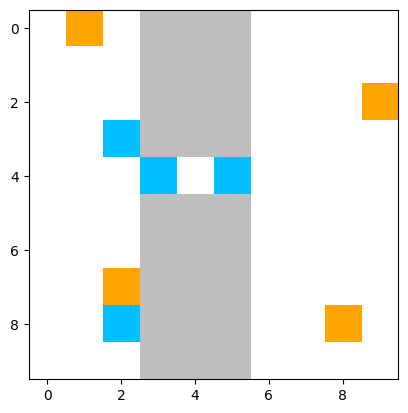

2024-06-17 18:35:35,732 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:40,132 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position and the direction from which I came, the best option to continue moving towards my destination without crashing into a wall would be to head south or north. However, going back north would be counterproductive as that's where I came from. Therefore, the optimal move would be to head south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:46,258 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates, I need to move towards the east to reach my destination. However, the east is blocked by a wall. Therefore, I will need to take a detour. The available directions for me are west, north, and south. Moving west will take me farther from my destination, so it's not the best option. Between north and south, choosing either won't make a significant difference in the distance to the destination. Therefore, I will choose to move north first, then reassess my position.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:50,767 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position at (5,5) and my goal to reach (2,2), I need to move west to decrease my x-coordinate and since my south is blocked by a wall, I can't move south to decrease my y-coordinate right now. Additionally, since I came from the east and cannot move north because it's blocked, my best option is to move west. 

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current scenario, I am at coordinates (3,5), and my destination is (1,9). Unfortunately, both my north and south are blocked by walls. Given that I just came from the east, and there's still a path to my west, my best option is to move west.

Final Answer: West

> Finished chain.


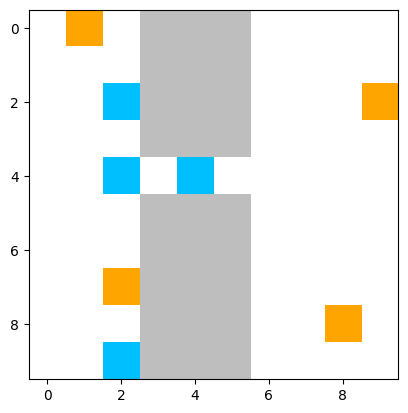

2024-06-17 18:35:54,584 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:35:59,944 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given that my current position is (2,0) and I am aiming to reach (8,1), I need to move towards the east. However, since my east is blocked by a wall, I cannot move in that direction. Considering my available options, moving west would take me further away from my destination. Since I came from north, moving there again would not be beneficial. Thus, the best option left is to move to the south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:08,051 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering that I am currently at (2,7) and my destination is (9,7), I need to move east. However, my way east is blocked by a wall. I came from the south, and going back is not a good option as it takes me away from my destination. My options then are to go west, north or stay.

Going west will take me further away from my destination along the x-axis, so it is not the best option. Staying will not get me closer to my destination.

Therefore, going north seems to be the best option even though it doesn't directly lead me to my destination. It may lead me to a path that allows me to go east.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:11,274 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering I am currently at (4,5) and I need to reach (2,2), and I can only move east or west while north and south are blocked. I came from the east, so the ideal move would be to go west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position (2,5) and my destination (1,9), I need to move towards the north to increase my y coordinate. However, since my x coordinate is greater than the x coordinate of my destination, I also need to move west at some point. Since I came from the east, I'll avoid backtracking and move north first.

Final Answer: North

> Finished chain.


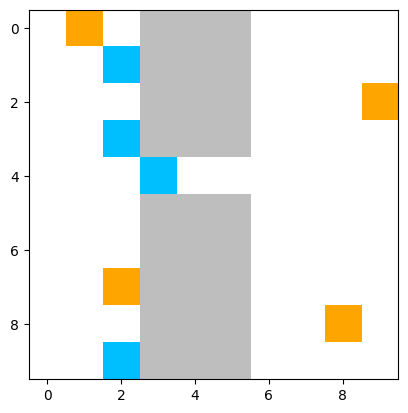

2024-06-17 18:36:17,372 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:23,569 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current position is (2,0) and my destination is (8,1), I need to move towards the east to reach my destination. However, my path east is blocked by a wall. I came from the north direction and I can't move back there. Therefore, my only options are to move either south or west. Since moving west will take me further away from my destination, my best option would be to move south in hopes of finding a path that leads me east.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:29,462 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current location at (2,8), my destination at (9,7), and the information about the surrounding terrains, I need to carefully choose my next move. I came from the south, east is blocked by a wall, to my west, north, and south lies a path. Considering my destination lies more towards the east, moving west would not be a logical choice. Going north may set me further away from my destination as it is in the lower region of the map. Therefore, moving south seems to be the most reasonable option at the moment. 

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:35,120 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates, I am at a higher position both vertically (y-axis) and horizontally (x-axis) compared to my destination. Since my south is blocked by a wall, I cannot move directly towards my destination. However, I can move west until I align with my destination on the x-axis. Once aligned, I can then move south. Therefore, my next move should be west.

Final Answer: West.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position (2,6) and my destination (1,9), and the fact that the east is blocked by a wall, the logical direction to choose would be north towards my target. However, as I came from the south, moving north would potentially lead me back the way I came. Moving west then north is the more sensible option to avoid repeating my path and to get closer to my target coordinates.

Final Answer: West

> Finished chain.


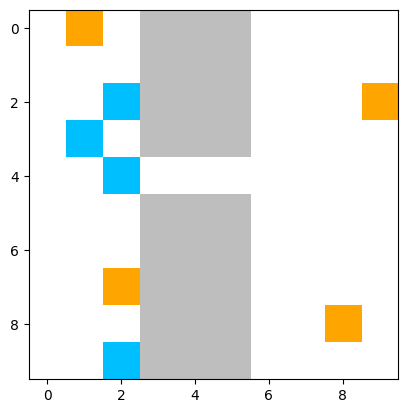

2024-06-17 18:36:40,251 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:45,957 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (2,0) and the destination (8,1), the most logical direction to move towards would be east. However, east is blocked by a wall. I came from the north, so returning there could lead me to a previous point. Hence, the best choice would be to either move south or west. Since moving west will decrease my x-coordinate, moving me further away from my destination, the optimal choice is to move south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:54,855 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I am currently at coordinates (2,7) and my destination is (9,7) which is more towards the east on the x-axis, my primary direction of movement should be east. However, the path to the east is blocked by a wall. My only options are to move west, south or north. I cannot move north because that's where I came from. Thus, between west and south, I need to choose the direction that will eventually allow me to move eastward. Without more information about the overall layout of the path, it's a bit tricky. But given the current details, my best bet would be to move south.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:36:58,637 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position is at (2,5) and my destination is at (2,2), I need to move towards the south in order to decrease my position on the y-axis and reach the destination. There are no obstacles mentioned in the south so it is safe to move in that direction.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering that my current location is (1,6) and my destination is (1,9), it appears that I need to move in the north direction along the y-axis in order to reach my destination. Since there is a path available in all directions, moving north will take me closer to my target.

Final Answer: North

> Finished chain.


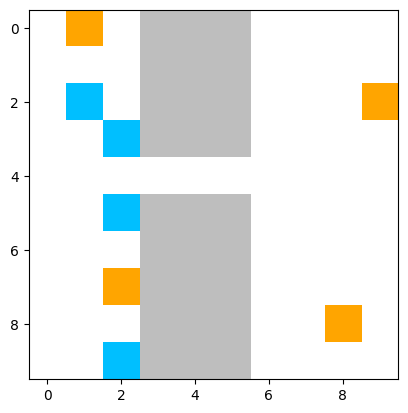

2024-06-17 18:37:02,804 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:07,396 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the location of the destination, I need to move towards the east to reach the destination from my current position. However, I am blocked by a wall on the east. Therefore, the most sensible move would be to take the path to the north, as I have just come from the west and moving south would take me further from the destination.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:19,408 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the current situation, I am at (2,6) and my destination is (9,7). Moving east is not an option because it's blocked by a wall. Since I came from the north, I don't want to go back in that direction as it will not bring me any closer to my destination. Therefore, my best options are to move either west or south. Considering the coordinates, if I move west, I will be moving away from my destination on the x-axis, which is not desirable. However, if I move south, I will stay on the same x-coordinate while changing the y-coordinate, which might bring me closer to my destination. Hence, the best choice for my next move would be to go south.
Final Answer: South.

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:24,161 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and the direction I need to go to reach my destination, the most logical move would be to go south as my destination is at (2,2) which is south of my current position. East is blocked and going west or north would take me farther from my destination. 

Final Answer: South.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position is (1,7) and my destination is (1,9), I need to move towards the north to reach my destination. Since there is a path to the north, my next move should be in that direction. 

Final Answer: North

> Finished chain.


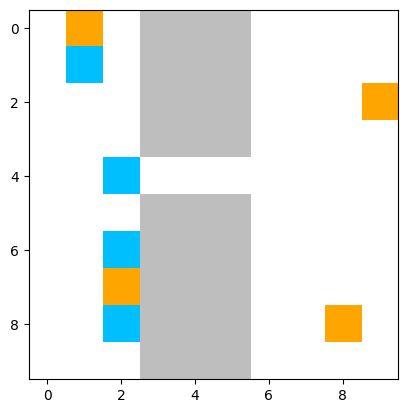

2024-06-17 18:37:27,840 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:31,097 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position at (1,8) and my destination at (1,9), as well as the fact that north corresponds to increasing y-axis values, it seems that the optimal direction to move next is north. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:35,437 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current location is (2,5) and my target location is (9,7), I need to move more towards the east and slightly towards the north. As I can only move in one direction at a time, I will prioritize moving east first because the gap along the x-axis is more significant. Also, since all directions have a path, there is no immediate barrier in moving east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:40,451 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position and the destination, I need to move towards the south. However, I need to remember that I came from the north. Hence, choosing to go back may lead me into a loop. The east is blocked, so my only options are either west or south. The goal is closer if I move south, so I will choose that.

Final Answer: South

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given that I came from the south and my goal is to reach (8,1) from my current position at (2,1), the most logical move would be to head west as it's the only viable path not leading me back. I can't move east because there's a wall and moving north or south would not bring me closer to my destination. 

Final Answer: West

> Finished chain.


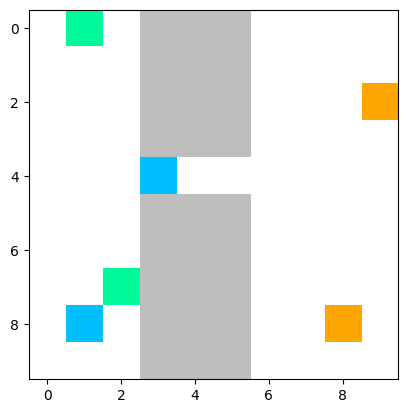

2024-06-17 18:37:45,788 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:49,397 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location and destination, I need to move towards the east to get closer to my destination. Since there is a path to the east, that would be the optimal move to make. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:52,443 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates (1,9) are the same as my destination (1,9), I have already reached my destination. Therefore, I do not need to move in any direction.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-17 18:37:54,443 - 24248 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since I am already at my destination coordinates (2,2), there is no need for me to move. 

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering that I am currently at (1,1) and my destination is (8,1), the most logical direction to move next is towards the east. This is because moving east will increase my x-coordinate, bringing me closer to my destination. Also, since I came from the east, it indicates that there is a clear path in that direction.

Final Answer: East

> Finished chain.


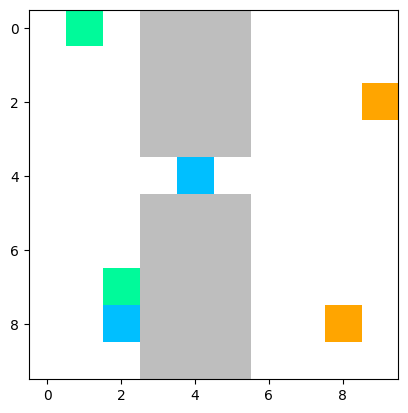

In [6]:
# 2 turn
for n in range(20):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_sets = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_sets for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]
  

  for connected_set in connected_sets:
    
    results = []

    for i in connected_set: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      results.append(result)

    env_copy = copy.deepcopy(env)
    planned_step = [0 for _ in range(num_agents)]
    for idx, agent_idx in enumerate(connected_set):
      planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
      collision = True
    else:
      collision = False

    if not collision:
      for idx, agent_idx in enumerate(connected_set):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
# 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
# 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
    else:
    # 먼저 prior agent는 원래대로 이동하게 함
      prior_agent_number = max(connected_set)
      prior_agent_idx = connected_set.index(prior_agent_number)
      action_list[prior_agent_number].append(results[prior_agent_idx])
      step[prior_agent_idx] = directiondict[results[prior_agent_idx]]
      for i in connected_set:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            give_way = tasks.give_way(agents_set[i], east, west, north, south, direction)

            crew = Crew(
                agents=[agents_set[i]],
                tasks=[give_way],
                verbose=0,
            )

            result = crew.kickoff()

            action_list[i] = []
    
            step[i] = directiondict[result]


  env.step(step)
  env.render()

### 교착상태 실험(잘 되면 위 코드로 넣기)

In [7]:
FOV_agents = []
for i in range(num_agents):
  if np.any(env.observe()[0][i][0][2:7, 2:7]):
    non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
    non_zero_elements = [element - 1 for element in non_zero_elements]
    non_zero_elements.append(i)
    FOV_agents.append(non_zero_elements)

connected_set = merge_sets(FOV_agents)
deadlocked_agents = [item for sublist in connected_set for item in sublist]
print(connected_set)

TypeError: 'list' object is not callable

In [38]:
# connected_set의 첫 번째 set에 대해 해결해보기 [0, 1]

results = []

for i in connected_set[0]: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

    a_obs = env.observe()[0][i][1]
    x = env.observe()[1][i][1]
    y = map_width-env.observe()[1][i][0]
    x_finish = toy[2][i][1]
    y_finish = map_width-toy[2][i][0]

    if a_obs[4][3] == 0:
        west = """To your west lies a path."""
    else:
        west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
        east = """To your east lies a path."""
    else:
        east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
        south = """To your south lies a path."""
    else:
        south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
        north = """To your north lies a path."""
    else:
        north = """Your north is blocked by a wall."""

    if len(action_list[i]) == 0:
        last_action = """"""
    elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
    elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
    elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
    elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
    elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
    else:
        last_action = """"""

    navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

    crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
    )

    result = crew.kickoff()

    results.append(result)


2024-06-17 16:34:57,388 - 29720 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-17 16:35:00,323 - 29720 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location and the destination, I need to move towards the east and slightly north. However, I can only make one move at a time. Since I have just moved from the north, I should first move eastward and then reassess the situation after that move.

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the current coordinates and the destination, I need to move along the x-axis. Since I'm currently at (3,7) and need to get to (2,7), it means I need to move west. My east and west paths are clear, so moving west should get me closer to my destination.

Final Answer: West

> Finished chain.


In [39]:
# 각각의 에이전트들의 원래 계획된 경로를 기반으로 충돌이 발생한다면 양보 프로세스로 넘어가게 함 (이 충돌 감지 부분을 gpt로 할지, 혹은 환경으로 할지)

# 충돌 감지 코드
env_copy = copy.deepcopy(env)
planned_step = [0 for _ in range(num_agents)]
for idx, agent_idx in enumerate(connected_set[0]):
    planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
        collision = True
    else:
        collision = False

In [40]:
collision

False

In [41]:
# 충돌하지 않는다면 원래 계획된 경로대로 가게 하고, action list에도 추가한다
if not collision:
    for idx, agent_idx in enumerate(connected_set[0]):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
# 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
# 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
else:
    # 먼저 prior agent는 원래대로 이동하게 함
    prior_agent_number = max(connected_set[0])
    prior_agent_idx = connected_set[0].index(prior_agent_number)
    action_list[prior_agent_number].append(results[prior_agent_idx])
    step[prior_agent_idx] = directiondict[results[prior_agent_idx]]
    for i in connected_set[0]:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            give_way = tasks.give_way(agents_set[i], east, west, north, south, direction)

            crew = Crew(
                agents=[agents_set[i]],
                tasks=[give_way],
                verbose=0,
            )

            result = crew.kickoff()

            action_list[i] = []
    
            step[i] = directiondict[result]

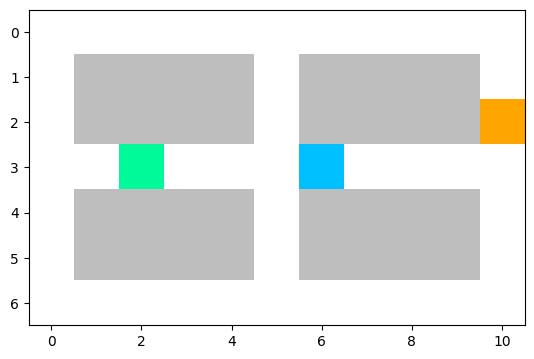

In [42]:
env.step(step)
env.render()